In [15]:
# This pipeline receives as input a sentence containing a masked word
# It outputs ranked completions (unlike other token-level algorithms, our approach is concept-based)
# Steps:
# Input: a sentence containing a masked word
# 0. Preprocess the input sentence
# 1. Retrieve the top-k completions according to BERT
# 2. Augmentation (by paraphrasing)
#   - Replace the masked word with BERT's first completion
#   - Use word-tune to create paraphrasing of the input sentence
#   - Mask all sentences
# 3. Use BERT to retrieve the top k possible completions and save their weights and conditional embeddings
# 4. Clean
#   4.0 Drop augmentations according to rank vectors (if drop_aug=True)
#   4.1 Drop sparse completions
# 5. Reduce the dimensionality
# 6. Cluster the remaining completions
# 7. Rank the clusters using the weights of the completions they contain

In [ ]:
# Download stopwords data

import nltk

nltk.download('stopwords')

print("NLTK 'stopwords' resource has been downloaded.")

NLTK 'stopwords' resource has been downloaded.


[nltk_data] Downloading package stopwords to /home/qtzx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


: 

In [ ]:
# # # IMPORTS # # #
import argparse
import torch
import transformers
import requests
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# NLTK and TextBlob
from nltk.corpus import stopwords
from textblob import TextBlob
import nltk

# Scikit-learn and SciPy
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import umap

# Transformers
from transformers import BertTokenizer, BertForMaskedLM, BertModel

/home/qtzx/Codebase/concept-aware-llms/baseline/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [ ]:
# # # CONFIGURATION / ARGUMENTS # # #
class Args:
    model_name = "bert-base-uncased"
    bert_top_k = 100
    set_name = "train"
    cluster_algo = "AgglomerativeClustering"
    drop_ratio = 0.45
    dist_func = "cosine_similarity"
    dim_red_algo = "comb"
    dim_red_n_comp = 30
    rank_weight = 0
    dbscan_eps_mult = 0.1
    dbscan_min_samples = 3
    alpha = 0.7
    drop_aug = False
    scatter_plot = True

args = Args()

: 

Original class & choices used:

def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--model_name",
        default="bert-base-uncased",
        type=str,
        required=False,
        help="Which BERT model to use."
    )
    parser.add_argument(
        "--bert_top_k",
        default=100,
        type=int,
        required=False,
        help="How many token completions from the top of BERT's ranked "
             "vocabulary to use for the concept-aware manipulation.",
    )
    parser.add_argument(
        "--set_name",
        default="train",
        # choices=["train", "test", "dev", "our_manual", "amazon_apparel_10k_head"],
        type=str,
        required=False,
        help="Which dataset to use. "
             "Options are (unless use a new dataset): [train, test, dev, our_manual, amazon_apparel_10k_head]"
    )
    parser.add_argument(
        "--cluster_algo",
        default="AgglomerativeClustering",
        choices=["AgglomerativeClustering", "DBSCAN"],
        type=str,
        required=False,
        help="Which clustering algorithm to use. Options are: [AgglomerativeClustering, DBSCAN]"
    )
    parser.add_argument(
        "--drop_ratio",
        default=0.45,
        type=float,
        required=False,
        help="Determines the amount of token completions to drop (due to sparsity). A function of #paraphrases.",
    )
    parser.add_argument(
        "--dist_func",
        default="cosine_similarity",
        choices=["cosine_similarity", "cosine_similarity", "pairwise_distances", "euc_rank", "min_aug"],
        type=str,
        required=False,
        help="Which distance function to use for the clustering. "
             "Possible options are: [cosine_similarity, cosine_similarity, pairwise_distances, euc_rank, min_aug]",
    )
    parser.add_argument(
        "--dim_red_algo",
        default="comb",
        choices=["comb", "umap", "pca", "tsne"],
        type=str,
        required=False,
        help="Which dimensionality reduction algorithm to use (combination of PCA and tSNE, UMAP, PCA, or tSNE)."
             "Possible options are: [comb, umap, pca, tsne]",
    )
    parser.add_argument(
        "--dim_red_n_comp",
        default=30,
        type=int,
        required=False,
        help="The dimension to reduce the data to.",
    )
    parser.add_argument(
        "--rank_weight",
        default=0,
        type=int,
        required=False,
        help="How much to consider the weights of the cluster-tokens when ranking the clusters.",
    )
    parser.add_argument(
        "--dbscan_eps_mult",
        default=0.1,
        type=float,
        required=False,
        help="The required epsilon (a function of the distance matrix of the data).",
    )
    parser.add_argument(
        "--dbscan_min_samples",
        default=3,
        type=int,
        required=False,
        help="The minimal number of data samples to form a cluster for DBSCAN.",
    )
    parser.add_argument(
        "--alpha",
        default=0.7,
        type=float,
        required=False,
        help="The weights on BERT's weights for the token clusters (relative to # of repetitions).",
    )
    parser.add_argument(
        "--drop_aug",
        default=False,
        action="store_true",
        required=False,
        help="Whether to drop paraphrases that have very different completions from the others."
    )
    parser.add_argument(
        "--scatter_plot",
        default=False,
        action="store_true",
        required=False,
        help="Whether to create a 2D plot (dim. red. using t-SNE) of the embedding space for visualisation."
    )

    return parser.parse_args()



In [ ]:
# # # HELPER FUNCTIONS (from original concept_bert_utilities.py) # # #

# Step 0
def get_df(set_name: str) -> pd.DataFrame:
    df = pd.read_csv("test.csv")
    return df

# Step 1, 3, 6
def get_bert_completion(sentence: str, pred_mlm, embd_lm, tokenizer, topk: int):
    text = f"[CLS] {sentence} [SEP]"
    tokenized_text = tokenizer.tokenize(text)
    masked_index = tokenized_text.index("[MASK]")
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    with torch.no_grad():
        outputs = pred_mlm(tokens_tensor)
        predictions = outputs[0]
    probs = torch.nn.functional.softmax(predictions[0, masked_index], dim=-1)
    top_k_weights, top_k_indices = torch.topk(probs, topk, sorted=True)
    completions, embeddings = [], []
    for i, pred_idx in enumerate(top_k_indices):
        predicted_token = tokenizer.convert_ids_to_tokens([pred_idx])[0]
        completions.append(predicted_token)
        embeddings.append(_get_embd(embd_lm, tokenizer, masked_index, tokenized_text.copy(), predicted_token).numpy())
    return completions, top_k_weights, embeddings

def _get_embd(model, tokenizer, masked_index: int, tokenized_text: list, predicted_token: str) -> torch.Tensor:
    tokenized_text[masked_index] = tokenizer.tokenize(predicted_token)[0]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2][1:]
    token_embeddings = hidden_states[-1]
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    return token_embeddings[masked_index]

def get_top_comp(sentence: str, pred_mlm, embd_lm, tokenizer, stopwords_set: set) -> str:
    top_k_completions, _, _ = get_bert_completion(sentence, pred_mlm, embd_lm, tokenizer, topk=200)
    try:
        top_comp = _filter_comp(top_k_completions, stopwords_set)[0]
    except IndexError:
        top_k_completions, _, _ = get_bert_completion(sentence, pred_mlm, embd_lm, tokenizer, topk=1000)
        top_comp = _filter_comp(top_k_completions, stopwords_set)[0]
    return top_comp

def _filter_comp(completions: list, stopwords_set: set) -> list:
    return [tok for tok in completions if len(tok) > 3 and tok not in stopwords_set]

# Step 2
def compl_rep_with_extra_id(sentence: str, comp: str) -> str:
    try:
        space_end_ind = sentence[sentence.index(comp) + len(comp):].index(" ") + sentence.index(comp) + len(comp)
        return f"{sentence[:sentence.index(comp)]}[MASK]{sentence[space_end_ind:]}"
    except ValueError:
        space_end_ind = len(sentence)
        return f"{sentence[:sentence.index(comp)]}[MASK]{sentence[space_end_ind:]}."

# Step 3
def get_aggr_data(paraphrases: list, pred_mlm, embd_lm, tokenizer, topk):
    completions_counter = defaultdict(int)
    completions_agg, weights_agg, embeddings_agg, rankings_agg = [], [], [], []
    for sen in paraphrases:
        completions, weights, embeddings = get_bert_completion(sen, pred_mlm, embd_lm, tokenizer, topk)
        completions_agg += completions
        weights_agg += [w.item() for w in weights]
        embeddings_agg += embeddings
        rankings_agg += list(np.arange(len(completions)))
        completions_counter = _counter_update(completions_counter, completions)
    return completions_agg, weights_agg, embeddings_agg, rankings_agg, completions_counter

def _counter_update(completions_counter: defaultdict, completions: list) -> defaultdict:
    for c in completions:
        completions_counter[c] += 1
    return completions_counter

# Step 4
def drop_sparse_completions(n_drop: int, completions_counter: defaultdict, stopwords_set: set, completions_agg: list, weights_agg: list, embeddings_agg: list, rankings_agg: list):
    com2drop = {c for c in completions_counter if completions_counter[c] < n_drop or len(c) < 3 or c in stopwords_set}
    ind_drop = [i for i, c in enumerate(completions_agg) if c in com2drop or "##" in c]
    
    completions_agg, weights_agg, embeddings_agg, rankings_agg = _drop_by_ind(completions_agg, weights_agg, embeddings_agg, rankings_agg, ind_drop)
    completions_agg, weights_agg, embeddings_agg, rankings_agg = _sorting(completions_agg, weights_agg, embeddings_agg, rankings_agg)
    return _merge_dup_completions(completions_agg, weights_agg, embeddings_agg, rankings_agg)

def _drop_by_ind(completions, weights, embeddings, rankings, indices):
    for i in sorted(indices, reverse=True):
        del completions[i], weights[i], embeddings[i], rankings[i]
    return completions, weights, embeddings, rankings

def _sorting(completions, weights, embeddings, rankings):
    ind = sorted(range(len(completions)), key=lambda k: completions[k])
    return [completions[i] for i in ind], [weights[i] for i in ind], [embeddings[i] for i in ind], [rankings[i] for i in ind]

def _merge_dup_completions(completions, weights, embeddings, rankings):
    if not completions:
        return [], [], defaultdict(list), defaultdict(), defaultdict(), defaultdict()
    
    completions_list, completion2embeddings, completion2weight, completion2rank, completion2rep = [], defaultdict(list), defaultdict(float), defaultdict(int), defaultdict(int)
    
    i = 0
    while i < len(completions):
        comp = completions[i]
        completions_list.append(comp)
        
        start = i
        while i < len(completions) and completions[i] == comp:
            completion2embeddings[comp].append(np.array(embeddings[i]))
            i += 1
        
        completion2weight[comp] = np.mean(weights[start:i])
        completion2rank[comp] = np.min(rankings[start:i])
        completion2rep[comp] = i - start

    embeddings_list = [np.mean(completion2embeddings[comp], axis=0) for comp in completions_list]
    return completions_list, embeddings_list, completion2weight, completion2embeddings, completion2rank, completion2rep

# Step 5
def scatter_plot(embeddings_list: list, completions_list: list, sentence: str):
    embeddings_agg_reduced = TSNE(n_components=2, init='pca', perplexity=min(10, len(embeddings_list) - 1)).fit_transform(np.array(embeddings_list))
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.scatter(embeddings_agg_reduced[:, 0], embeddings_agg_reduced[:, 1])
    for i, txt in enumerate(completions_list):
        ax.annotate(txt, (embeddings_agg_reduced[i, 0], embeddings_agg_reduced[i, 1]))
    plt.title(f"t-SNE for: {sentence}")
    plt.show()

def get_embd_dim_red(dim_red_algo: str, embeddings_list: list, completions_list: list, dim_red_n_comp: int):
    if dim_red_algo == "comb":
        embeddings_agg_reduced = comb_dim_red(embeddings_list, n_components=dim_red_n_comp)
    else:
        embeddings_agg_reduced = dim_red(embeddings_list, dim_red_algo=dim_red_algo, n_components=dim_red_n_comp)
    
    completion2embeddings_red = {key: embeddings_agg_reduced[i] for i, key in enumerate(completions_list)}
    return embeddings_agg_reduced, completion2embeddings_red

def comb_dim_red(embeddings_agg: list, n_components: int) -> np.ndarray:
    pca_red = PCA(n_components=min(100, len(embeddings_agg))).fit_transform(np.array(embeddings_agg))
    tsne_n_components = min(n_components, pca_red.shape[0] - 1)
    return TSNE(n_components=tsne_n_components, init='pca', perplexity=min(10, pca_red.shape[0] - 1), method='exact').fit_transform(pca_red)

def dim_red(embeddings_agg: list, dim_red_algo: str, n_components: int) -> np.ndarray:
    if dim_red_algo == "umap":
        return umap.UMAP(n_components=n_components).fit_transform(np.array(embeddings_agg))
    # ... other dim_red functions

# Step 6
def get_agglo_clusters(embeddings_agg_reduced, completions_list, completion2rank, rank_weight, dist_func):
    dist_mat = _dist_func(embeddings_agg_reduced, completions_list, completion2rank, rank_weight, dist_func)
    normalized_dist_mat = (dist_mat - dist_mat.min()) / (dist_mat.max() - dist_mat.min())
    cluster_algo = AgglomerativeClustering(metric="precomputed", linkage="complete", distance_threshold=0.45, n_clusters=None, compute_distances=True)
    clusters = cluster_algo.fit_predict(normalized_dist_mat)
    return clusters, normalized_dist_mat, cluster_algo

def plot_dendrogram(model, sentence: str, completions_list: list):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = sum(1 if child_idx < n_samples else counts[child_idx - n_samples] for child_idx in merge)
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    plt.figure(figsize=(15, 7))
    dendrogram(linkage_matrix, labels=completions_list, leaf_rotation=90)
    plt.title(f'Dendrogram for: {sentence}')
    plt.show()

def _dist_func(embeddings, completions, rankings, rank_weight, dist_func):
    if dist_func == "cosine_similarity":
        return 1 - cosine_similarity(embeddings)
    # ... other dist functions

def cluster_processing(clusters, completions, weights, ranks, reps, top_k, alpha):
    cluster_data = defaultdict(lambda: {'words': [], 'weights': [], 'ranks': [], 'reps': []})
    for i, comp in enumerate(completions):
        label = clusters[i]
        cluster_data[label]['words'].append(comp)
        cluster_data[label]['weights'].append(weights[comp])
        cluster_data[label]['ranks'].append(ranks[comp])
        cluster_data[label]['reps'].append(reps[comp])

    processed = {}
    for label, data in cluster_data.items():
        if label == -1: continue
        best_comp_idx = np.argmax(alpha * np.array(data['weights']) + (1 - alpha) * np.array(data['reps']))
        processed[label] = {
            'words': data['words'],
            'best_comp': data['words'][best_comp_idx],
            'weight': max(data['weights']),
            'rep': max(data['reps'])
        }
    return processed

# Step 7
def get_ranked_clusters(clusters, top_k_completions):
    # Simplified ranking
    print("--- Ranked Clusters ---")
    for i, (label, data) in enumerate(clusters.items()):
        try:
            b_r = top_k_completions.index(data['best_comp'])
        except ValueError:
            b_r = -1
        print(f"Cluster {i} (label={label}): Best='{data['best_comp']}' (BERT rank={b_r}), Words={data['words']}")
    return clusters

: 

In [ ]:
# # # PRE-LOADS & STEP 0 # # #
print("Loading models...")
tokenizer = BertTokenizer.from_pretrained(args.model_name)
pred_mlm = BertForMaskedLM.from_pretrained(args.model_name)
pred_mlm.eval()
embd_lm = BertModel.from_pretrained(args.model_name, output_hidden_states=True)
embd_lm.eval()
stopwords_set = set(stopwords.words('english'))
print("Models loaded.")

print("\nStep 0: Loading and preprocessing data...")
df = get_df(args.set_name)
sentence = df.test[0] # 
print(f"Original: {sentence}")
sentence = sentence.replace("<id_0>", "[MASK]")
print(f"Masked: {sentence}")


Loading models...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Models loaded.

Step 0: Loading and preprocessing data...
Original: Jnaki is a  <id_0>.
Masked: Jnaki is a  [MASK].


: 

In [ ]:
# # # # STEP 1: Retrieve Top Completions # # # #
print("\nStep 1: Retrieving top completions...")
top_comp = get_top_comp(sentence, pred_mlm, embd_lm, tokenizer, stopwords_set)
print(f"Top completion: '{top_comp}'")


Step 1: Retrieving top completions...
Top completion: 'footballer'


: 

In [ ]:
# # # # STEP 2: Augmentation # # # #
print("\nStep 2: Augmenting (paraphrasing is disabled)...")
completed_sentence = sentence.replace("[MASK]", top_comp)
paraphrases = [sentence]
print(f"Processing {len(paraphrases)} sentence(s).")



Step 2: Augmenting (paraphrasing is disabled)...
Processing 1 sentence(s).


: 

In [ ]:
# # # # STEP 3: Get Aggregated Data # # # #
print("\nStep 3: Aggregating completion data...")
completions_agg, weights_agg, embeddings_agg, rankings_agg, completions_counter = get_aggr_data(
    paraphrases, pred_mlm, embd_lm, tokenizer, topk=args.bert_top_k)
print(f"Aggregated {len(completions_agg)} completions.")


Step 3: Aggregating completion data...
Aggregated 100 completions.


: 

In [ ]:
# # # # STEP 4: Clean Data # # # #
print("\nStep 4: Cleaning data...")
completions_list, embeddings_list, completion2weight, _, completion2rank, completion2rep =     drop_sparse_completions(
        int(len(paraphrases) * args.drop_ratio),
        completions_counter, stopwords_set,
        completions_agg, weights_agg, embeddings_agg, rankings_agg
    )
print(f"Remaining completions after cleaning: {len(completions_list)}")


Step 4: Cleaning data...
Remaining completions after cleaning: 100


: 

Step 5: Reducing dimensionality...
Creating 2D scatter plot...


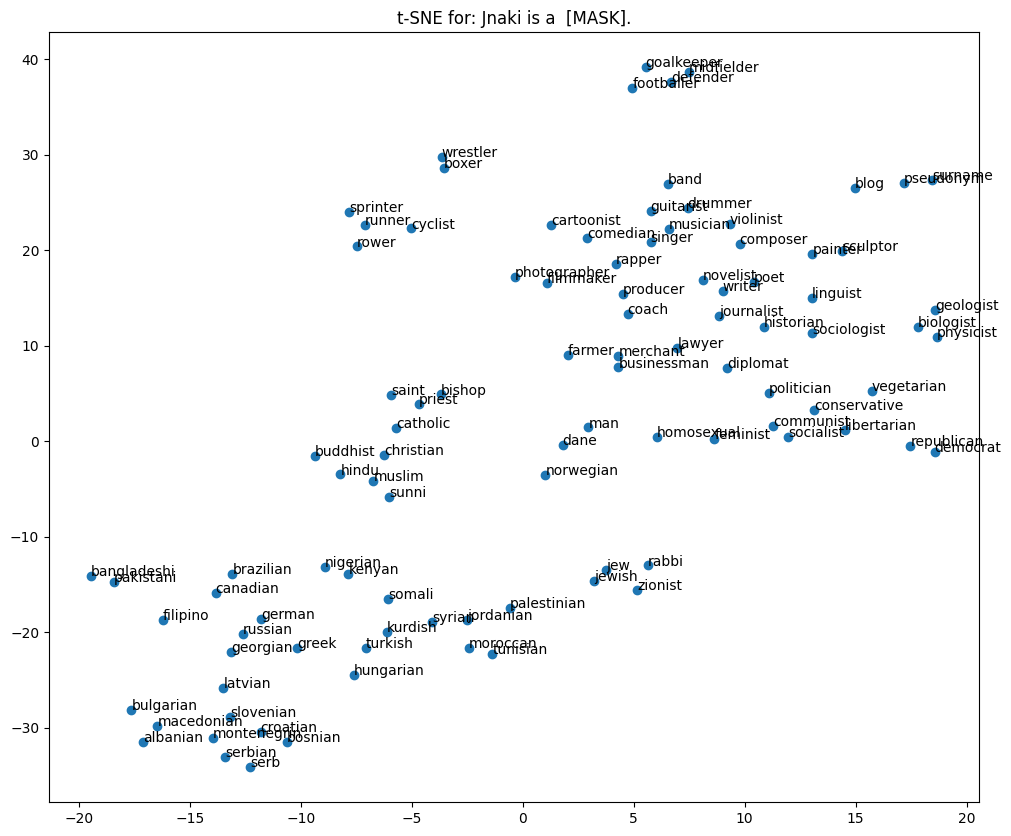

Dimensionality reduced to: (100, 30)


: 

In [ ]:
# # # # STEP 5: Reduce Dimensionality # # # #
print("Step 5: Reducing dimensionality...")

# Safety check: Ensure we have enough data points to proceed
# PCA/TSNE and clustering need at least 2-3 points to be meaningful.
if len(embeddings_list) > 2:
    if args.scatter_plot:
        print("Creating 2D scatter plot...")
        scatter_plot(embeddings_list, completions_list, sentence)

    embeddings_agg_reduced, _ = get_embd_dim_red(
        args.dim_red_algo, embeddings_list, completions_list, args.dim_red_n_comp)
    print(f"Dimensionality reduced to: {embeddings_agg_reduced.shape}")
    
    # A flag to indicate that the next steps can run
    can_cluster = True
else:
    print(f"Skipping dimensionality reduction and clustering: not enough data points ({len(embeddings_list)}).")
    # Create a placeholder to avoid errors and set the flag
    embeddings_agg_reduced = []
    can_cluster = False


Step 6: Clustering completions...


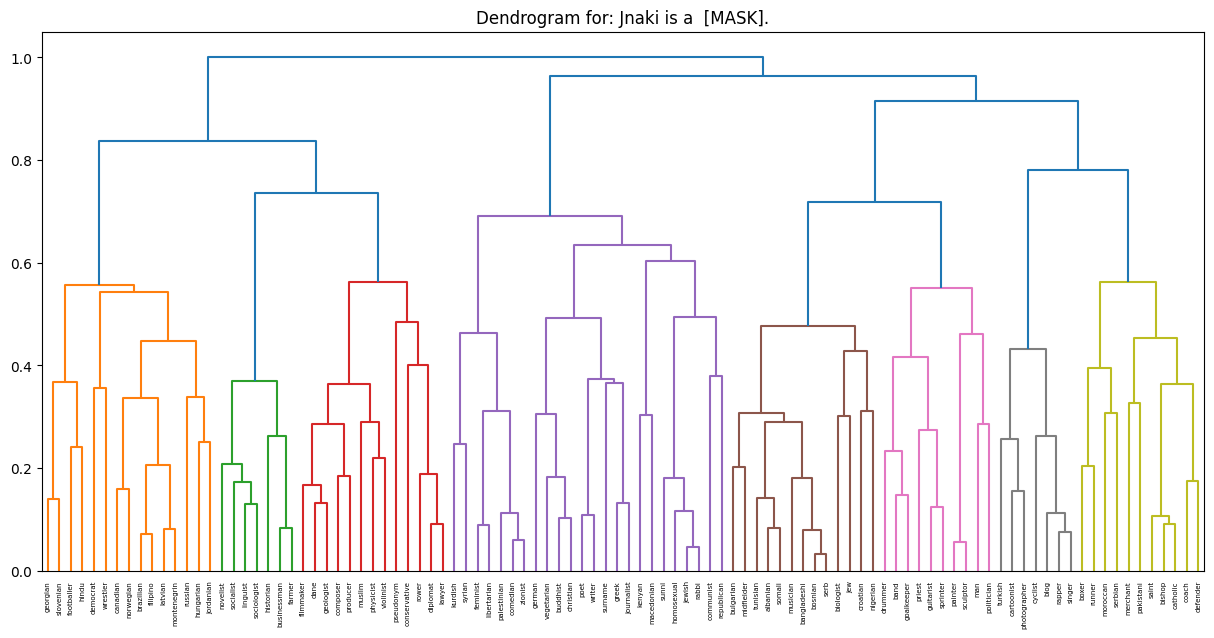

Found 23 clusters.


: 

In [ ]:
# # # # STEP 6: Cluster Completions # # # #
if can_cluster:
    print("\nStep 6: Clustering completions...")
    clusters, _, trained_cluster_algo = get_agglo_clusters(
        embeddings_agg_reduced, completions_list, completion2rank,
        args.rank_weight, args.dist_func
    )
    plot_dendrogram(trained_cluster_algo, sentence, completions_list)

    processed_clusters = cluster_processing(
        clusters, completions_list, completion2weight,
        completion2rank, completion2rep, args.bert_top_k, args.alpha
    )
    print(f"Found {len(processed_clusters)} clusters.")
else:
    print("Skipping Step 6 because there were not enough data points.")

In [ ]:
# # # # STEP 7: Rank Clusters # # # #
if can_cluster:
    print("\nStep 7: Ranking clusters...")
    # We need to get the original top_k_completions to compare ranks against
    top_k_completions_all, _, _ = get_bert_completion(
        sentence, pred_mlm, embd_lm, tokenizer, topk=args.bert_top_k)
    
    # The get_ranked_clusters function expects a list of strings
    top_k_completions_list = [comp for comp in top_k_completions_all]

    ranked_clusters = get_ranked_clusters(processed_clusters, top_k_completions_list)
else:
    print("Skipping Step 7 because clustering was not performed.")



Step 7: Ranking clusters...
--- Ranked Clusters ---
Cluster 0 (label=9): Best='midfielder' (BERT rank=6), Words=['albanian', 'bangladeshi', 'bosnian', 'bulgarian', 'midfielder', 'musician', 'serb', 'somali', 'tunisian']
Cluster 1 (label=6): Best='goalkeeper' (BERT rank=16), Words=['band', 'drummer', 'goalkeeper', 'guitarist', 'priest', 'sprinter']
Cluster 2 (label=1): Best='nigerian' (BERT rank=11), Words=['biologist', 'croatian', 'jew', 'nigerian']
Cluster 3 (label=4): Best='defender' (BERT rank=24), Words=['bishop', 'catholic', 'coach', 'defender', 'saint']
Cluster 4 (label=2): Best='rapper' (BERT rank=8), Words=['blog', 'cartoonist', 'cyclist', 'photographer', 'rapper', 'singer', 'turkish']
Cluster 5 (label=5): Best='serbian' (BERT rank=26), Words=['boxer', 'moroccan', 'runner', 'serbian']
Cluster 6 (label=0): Best='hungarian' (BERT rank=10), Words=['brazilian', 'canadian', 'filipino', 'hungarian', 'jordanian', 'latvian', 'montenegrin', 'norwegian', 'russian']
Cluster 7 (label=17):

: 

In [ ]:
# Citation
# This code is based on the work from the EMNLP 2023 paper, "Towards Concept-Aware Large Language Models."

: 

@inproceedings{shani-etal-2023-towards,
    title = "Towards Concept-Aware Large Language Models",
    author = "Shani, Chen  and
      Vreeken, Jilles  and
      Shahaf, Dafna",
    editor = "Bouamor, Houda  and
      Pino, Juan  and
      Bali, Kalika",
    booktitle = "Findings of the Association for Computational Linguistics: EMNLP 2023",
    month = dec,
    year = "2023",
    address = "Singapore",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2023.findings-emnlp.877",
    doi = "10.18653/v1/2023.findings-emnlp.877",
    pages = "13158--13170",
    abstract = "Concepts play a pivotal role in various human cognitive functions, including learning, reasoning and communication. However, there is very little work on endowing machines with the ability to form and reason with concepts. In particular, state-of-the-art large language models (LLMs) work at the level of tokens, not concepts. In this work, we analyze how well contemporary LLMs capture human concepts and their structure. We then discuss ways to develop concept-aware LLMs, taking place at different stages of the pipeline. We sketch a method for pretraining LLMs using concepts, and also explore the simpler approach that uses the output of existing LLMs. Despite its simplicity, our proof-of-concept is shown to better match human intuition, as well as improve the robustness of predictions. These preliminary results underscore the promise of concept-aware LLMs.",
}